In [2]:
#データ解析用ライブラリ
import pandas as pd
import numpy as np

In [3]:
#データ可視化ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#LightGBMライブラリ
import lightgbm as lgb

In [5]:
#訓練データとモデル評価用データに分けるライブラリ
from sklearn.model_selection import train_test_split

In [6]:
#csvデータの読み込み
solar_data = pd.read_csv(r'C:\Users\Takeshi Watanabe\Documents\jupyter-notebook\2015_winter data.csv', engine='python')

In [7]:
# 終値を1日分移動させる
solar_data_shift = solar_data
solar_data_shift.EPG = solar_data_shift.EPG.shift(-24)

In [8]:
# 改めてデータを確認
solar_data_shift.tail()

,�ｻｿpeak AM,peak PM,solar irradiance,temperature,cloud,EPG
1770,0,0,0.0,12.9,9,NaN
1771,0,0,0.0,11.5,9,NaN
1772,0,0,0.0,11.2,2,NaN
1773,0,0,0.0,10.5,2,NaN
1774,0,0,0.0,9.4,2,NaN


In [9]:
# 1日分の行を除外
solar_data_shift = solar_data_shift[:-24]
 
# 念のためデータをdf_2として新しいデータフレームへコピ−
df_2 = solar_data_shift.copy()
 
 
# データセットのサイズを確認
print(df_2.shape[0])
print(df_2.shape[1])

1751
6


In [10]:
train_set, test_set = train_test_split(df_2, test_size=0.2, random_state=4)

In [11]:
print(len(train_set))
print(len(test_set))

1400
351


In [12]:
#訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
X_train = train_set.drop('EPG', axis=1)
y_train = train_set['EPG']

In [13]:
#モデル評価用データを説明変数データ(X_train)と目的変数データ(y_train)に分割
X_test = test_set.drop('EPG', axis=1)
y_test = test_set['EPG']

In [14]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)
params = {'metric': 'rmse',
          'max_depth' : 6}

In [15]:
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval,
                num_boost_round=10000,
                early_stopping_rounds=100,
                verbose_eval=50)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 5
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3.200858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [16]:
predicted = gbm.predict(X_test)

In [17]:
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [18]:
#予測値と正解値を描写する関数
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred']) 
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

pred_df = pd.concat([y_test.reset_index(drop=True), pd.Series(predicted)], axis=1)
pred_df.columns = ['true', 'pred']

In [19]:
pred_df.head()

,true,pred
0,10.9898,13.715012
1,0.0000,1.698596
2,0.0000,0.109203
3,15.5820,14.238722
4,0.0000,0.104412


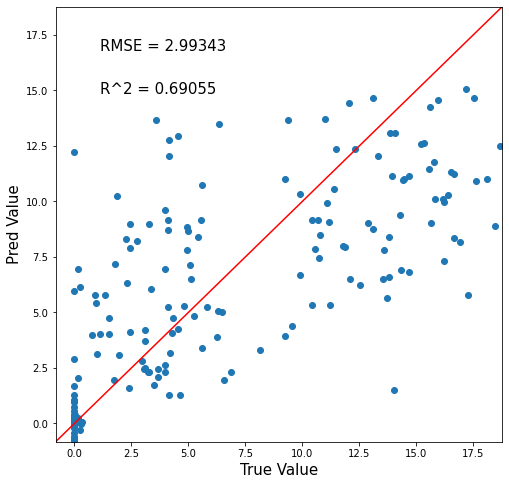

In [20]:
True_Pred_map(pred_df)

C:\Users\Takeshi Watanabe\anaconda3\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 65403 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Takeshi Watanabe\anaconda3\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 65407 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Takeshi Watanabe\anaconda3\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 65403 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Takeshi Watanabe\anaconda3\envs\py36\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 65407 missing from current font.
  font.set_text(s, 0, flags=flags)


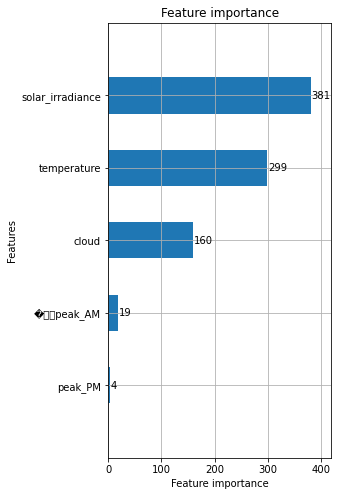

In [21]:
lgb.plot_importance(gbm, height=0.5, figsize=(4,8))

In [22]:
RMSE_list = []
count = []
for i in range(1, 15):
    params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'max_depth' : i}
    
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_eval,
                early_stopping_rounds=100,
                verbose_eval=50)
    
    predicted = gbm.predict(X_test)
    pred_df = pd.concat([y_test.reset_index(drop=True), pd.Series(predicted)], axis=1)
    pred_df.columns = ['true', 'pred']
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    RMSE_list.append(RMSE)
    count.append(i)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 5
[LightGBM] [Info] Start training from score 3.200858
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 3.22581
[100]	valid_0's rmse: 3.18324
[150]	valid_0's rmse: 3.18012
[200]	valid_0's rmse: 3.17896
[250]	valid_0's rmse: 3.17895
[300]	valid_0's rmse: 3.17909
Early stopping, best iteration is:
[245]	valid_0's rmse: 3.17802
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 5
[LightGBM] [Info] Start training from score 3.200858
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 5
[LightGBM] [Info] Start training from score 3.200858
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

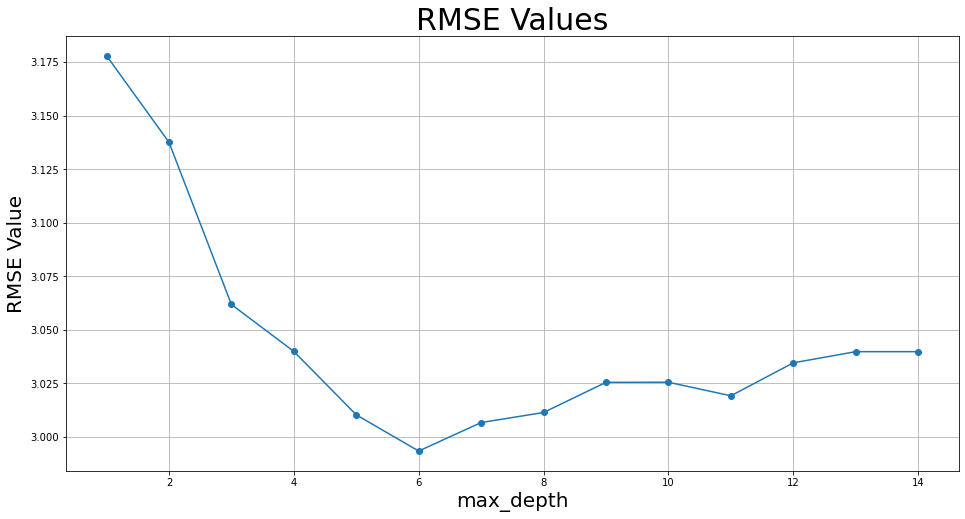

In [23]:
plt.figure(figsize=(16,8))
plt.plot(count, RMSE_list, marker="o")
plt.title("RMSE Values", fontsize=30)
plt.xlabel("max_depth", fontsize=20)
plt.ylabel("RMSE Value", fontsize=20)
plt.grid(True)

In [24]:
import matplotlib.pyplot as plt

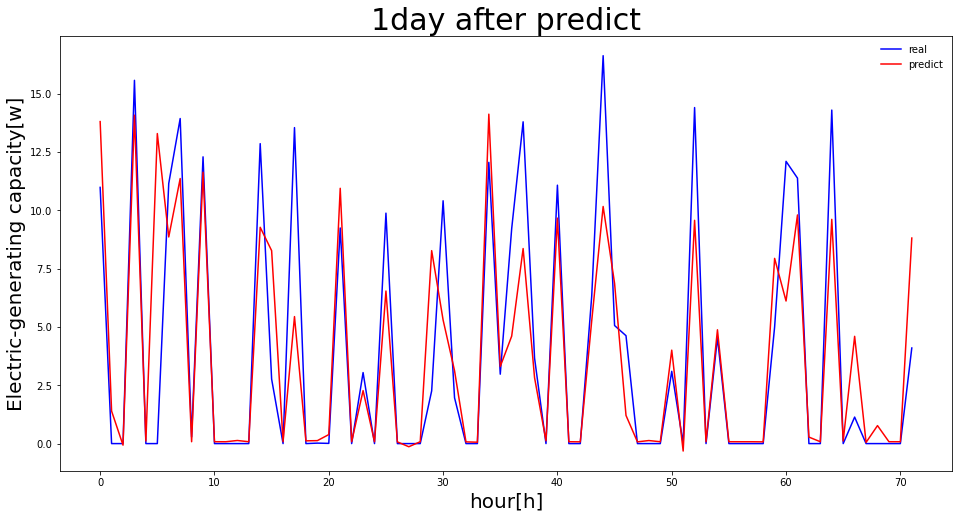

In [25]:
# 予測と実際のテストの終値のチャートをプロットしてみよう
plt.ion()
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot()
line1, = ax1.plot(pred_df['true'].head(72),'-b',label='real')
line2, = ax1.plot(pred_df['pred'].head(72),'-r',label='predict')
leg = ax1.legend(frameon=False)
plt.xlabel('hour[h]',fontsize=20)
plt.ylabel('Electric-generating capacity[w]',fontsize=20)
plt.title('1day after predict',fontsize=30)
plt.show()